# Capstone Project - Finding the best place to open a coffee shop in Oslo
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data processing](#data)
* [Methodology](#methodology)
* [Exploratory Data Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find an optimal location for a food shop. Specifically, this report will be targeted to stakeholders interested in opening a coffee shop in Oslo, Norway.
First of all, notice that it is not a torough study, as we make some simplifications in order to follow the capstone project. Moreover, the Foursquare API we use in order to give us places on interest (e.g. coffee shops or related) don't return every coffee shop in area, as it is also feeded by users around the world. The purpose of this project is then to provide useful insights as a supplementary decision tool for relevant stakeholders.

The steps which are mandatory for this capstone project are :
- Collecting some data of boroughs/neighborhoods of a town of interest
- Using Foursquare API to find venues of interest



Since they are already many coffee shops in Oslo, the task is not so easy. We also limit our analysis to data analysis, not marketing, business market study, and so on. What we are going to look, is places with a minimum coffee shops but maximum of other kind of stores and shops if possible. A good place would then be where there are very few coffee shops, but many stores (so it is quite crowded). By coffee shop, we mean also other similar venues in our analysis, like bakeries, pastries, bar,... and all kind of shops where it is easy to find hot drinks. For example, restaurants are not direct competitors as well as shops which are rather providers of customers.

Other criterion suggested in the course, would be as closest as possible from the center of Oslo, but looking for maximum shops is a good alternative too, as it includes also 
some shopping centers/neighborhoods, which are not necessarily in downtown. 

We will use our data science tools to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

In [235]:
# IMPORTING USEFUL PACKAGES

import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
from bs4 import BeautifulSoup


print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Libraries imported.


## Data Processing <a name="data"></a>

Based on definition of our problem, factors that will influence our decisions are:
* number of existing coffee shops in the neighborhood (any type of "cafe", "bar", )
* number of existing places for shopping

The list of our boroughs and neighborhoods comes from Wikipedia, which we are going to scrap using BeautifulSoup. We will put this data into a Pandas dataframe, in 
order to manipulate it easily.

Following data sources will be needed to extract/generate the required information:
* approximate center coordinates of each borough/neighborhood or venue of interest will be done with help of **geopy** package.
* number of coffee shops or related (pastries, bakeries,...), and location in every neighborhood, will be obtained using **Foursquare API**

### Collecting data from Wikipedia (scrapping)

In [236]:
url = "https://no.wikipedia.org/wiki/Delbydeler_i_Oslo"
r = requests.get(url)
html = r.text

In [237]:
soup = BeautifulSoup(html, "html.parser")

#### A) Collecting boroughs

In [238]:
import re

list_bor =[]

borough = soup.find_all('span', 'mw-headline')

for name in borough:
    x = re.sub('\d', '', name.get_text())
    x = x.strip()
    list_bor.append(x)

Some outputs must be removed :
- the first string 'Delbydeler i Oslo' is not a neighborhood, this is the title
- Marka, Se også and Kilder are outliers (outside of Oslo administative boudaries)

So we kept only the 16 boroughs of Oslo. Sentrum is not a borough in the strict administrative, but it is a very important geographical area (Oslo downtown!), so we need to keep it.
For the neighborhoods, the html code of the wikipedia page is very raw, and there is no link parents - child between boroughs and neighborhoods that we can use with BeautifulSoup. 
There is only tags of kind \<ul\> and \<li\> which mean unorganized list...
So we need to scrap the data in a quite tedious way, as we have to pack neighborhoods to the right boroughs.

In [239]:
# delete the unwanted data
del list_bor[0]
del list_bor[16:19]
list_bor

['Gamle Oslo',
 'Grünerløkka',
 'Sagene',
 'St. Hanshaugen',
 'Frogner',
 'Ullern',
 'Vestre Aker',
 'Nordre Aker',
 'Bjerke',
 'Grorud',
 'Stovner',
 'Alna',
 'Østensjø',
 'Nordstrand',
 'Søndre Nordstrand',
 'Sentrum']

#### B) Collecting neighborhoods

In [240]:
# second part, recover the neighborhoods names : simple but raw data

neighborhoods = soup.find_all('li')
list_neigh = []
# the range correspond to the relevant data (i have checked before what was the output)
for i in range(20,112):
    x = re.sub('\d', '', neighborhoods[i].get_text())
    x = x.strip()
    list_neigh.append(x)

In [241]:
list_neigh.append('Sentrum') # Sentrum is not considered as administrive district despite it is the most famous in Oslo !

We will affect then neighborhoods to the right borough by slicing our previous output into 16 pieces corresponding to each borough

In [242]:
# third part, packing neighborhoods for each borough : tedious
neigh = [list_neigh[0:7],
        list_neigh[7:14],
        list_neigh[14:19],
        list_neigh[19:24],
        list_neigh[24:32],
        list_neigh[32:37],
        list_neigh[37:44],
        list_neigh[44:52],
        list_neigh[52:56],
        list_neigh[56:61],
        list_neigh[61:67],
        list_neigh[67:74],
        list_neigh[74:80],
        list_neigh[80:86],
        list_neigh[86:92],
        list_neigh[92:]
        ]

In [243]:
# then finally put them into a dataframe
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame(list_bor, columns = ['Borough'])
df['Neighborhoods'] = neigh
df

,Borough,Neighborhoods
0,Gamle Oslo,"[Lodalen, Grønland, Enerhaugen, Nedre Tøyen, Kampen, Vålerenga, Helsfyr]"
1,Grünerløkka,"[Grünerløkka vest, Grünerløkka øst, Dælenenga, Rodeløkka, Sinsen, Sofienberg, Hasle-Løren]"
2,Sagene,"[Iladalen, Sagene, Bjølsen, Sandaker, Torshov]"
3,St. Hanshaugen,"[Hammersborg, Bislett, Ila, Fagerborg, Lindern]"
4,Frogner,"[Bygdøy, Frogner, Frognerparken, Majorstuen nord, Majorstuen syd, Homansbyen, Uranienborg, Skillebekk]"
5,Ullern,"[Ullernåsen, Lilleaker, Ullern, Montebello-Hoff, Skøyen]"
6,Vestre Aker,"[Røa, Holmenkollen, Hovseter, Holmen, Slemdal, Grimelund, Vinderen]"
7,Nordre Aker,"[Disen, Myrer, Grefsen, Kjelsås, Korsvoll, Tåsen, Nordberg, Ullevål hageby]"
8,Bjerke,"[Veitvet, Linderud, Økern, Årvoll]"
9,Grorud,"[Ammerud, Rødtvet, Nordtvet, Grorud, Romsås]"


#### C) Associate each neighborhood to a single borough (the one he belongs)

For this, we create a function which append k times a given variable elem in a list :

In [244]:
def copy_element(k,elem, liste):
    for i in range(0,k):
        liste.append(elem)
    return liste

In [245]:
# list of boroughs duplicates according to the corresponding neighborhoods
list_borough = []
for i in df.index:
    copy_element(len(df.loc[i,'Neighborhoods']), list_bor[i],list_borough)

In [246]:
# create a dictionnary and packing everything into a dataframe
dic = {"Borough" : list_borough, "Neighborhood" : list_neigh}
data = pd.DataFrame.from_dict(dic)
data.head(5)

,Borough,Neighborhood
0,Gamle Oslo,Lodalen
1,Gamle Oslo,Grønland
2,Gamle Oslo,Enerhaugen
3,Gamle Oslo,Nedre Tøyen
4,Gamle Oslo,Kampen


Now we have the tab of neighborhoods and their corresponding borough. Now, we have to recover the coordinates.

Remark : From a practical point of view, a simple copy/paste in an excel tab is much faster ! I used scrapping only for an educational purpose (mine!)

#### D) Getting the latitude/longitude parameters of each neighborhood

In [247]:
# Check on example with a neighborhood
address = 'Lodalen, Gamle Oslo, Oslo, NO'

geolocator = Nominatim(user_agent="test_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(location)
print(latitude,longitude)

Lodalen, Gamle Oslo, Oslo, Norge
59.90466055 10.77869333319595


In [248]:
# now let make a loop for all neighborhoods
list_latitude = []
list_longitude = []
geolocator = Nominatim(user_agent="oslo_agent")

from tqdm.auto import tqdm # useful to vizualise running time, around 45 seconds min

for borough, neigh in tqdm(zip(data['Borough'].values, data['Neighborhood'].values)):
    address = '{},{},Oslo, NO'.format(neigh,borough)
    geolocator = Nominatim(user_agent="oslo_agent")
    location = geolocator.geocode(address)
    if location is None:
        print(neigh)
    #list_latitude.append(location.latitude)
    #list_longitude.append(location.longitude)


Nedre Tøyen
Grünerløkka vest
Grünerløkka øst
Majorstuen nord
Majorstuen syd
Holmlia syd
Holmlia nord



Some address return "None object", we replace them by a comprehensive adress according to geopy:

In [249]:
old_list = ['Nedre Tøyen', 'Grünerløkka vest', 'Grünerløkka øst' , 'Majorstuen nord', 'Majorstuen syd' , 'Holmlia syd', 'Holmlia nord']
new_list = ['Tøyen','Grünerløkka','Grünerløkka', 'Majorstuen', 'Majorstuen', 'Holmlia', 'Holmlia']
data.replace(old_list, new_list, inplace = True)
data.drop_duplicates(inplace = True, ignore_index = True)

In [250]:
# now the loop for all neighborhoods and creation of the dataframe
list_latitude = []
list_longitude = []
geolocator = Nominatim(user_agent="oslo_agent")

from tqdm.auto import tqdm # useful to vizualise running time, around 45 seconds min

for borough, neigh in tqdm(zip(data['Borough'].values, data['Neighborhood'].values)):
    address = '{},{},Oslo, NO'.format(neigh,borough)
    geolocator = Nominatim(user_agent="oslo_agent")
    location = geolocator.geocode(address)
    list_latitude.append(location.latitude)
    list_longitude.append(location.longitude)

In [251]:
# putting all borough and neighborhoods in a lists (useful for future analysis)
oslo_borough = data.Borough.to_list()
oslo_neighborhoods = data.Neighborhood.to_list()

In [252]:
# Complete dataframe with adresses

data['Latitude'] = list_latitude
data['Longitude'] = list_longitude
data.head(5)

,Borough,Neighborhood,Latitude,Longitude
0,Gamle Oslo,Lodalen,59.904661,10.778693
1,Gamle Oslo,Grønland,59.912795,10.760161
2,Gamle Oslo,Enerhaugen,59.913294,10.769124
3,Gamle Oslo,Tøyen,59.915757,10.775795
4,Gamle Oslo,Kampen,59.912731,10.780247


##### Our data is now clean, with 90 neighborhoods, the distinction between East and West in some neighborhoods is not supported by geopy. 
As we will see later, these administrative partition of Oslo is not the commun used by people: indeed, many others neighborhoods which are subpartition of 
these administraves ones will come.

In [253]:
data.shape

(90, 4)

### Folium Map of borough / neighborhoods locations

In [254]:
address = 'Oslo, NO'

geolocator = Nominatim(user_agent="oslo_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Oslo are 59.9133301, 10.7389701.


In [255]:
# create map of Oslo using latitude and longitude values of Oslo as starting point

map_oslo = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Oslo that have low coffee shop density, and many store/shopping center.

**First Step : Finding all venues of interest, which scale ?**

Usually, people use radius = 500 for a request in Foursquare API, which means that we ask the API to give every venue in circle of 500m radius 
around the given set of coordinates (e.g. lat/lon) which in our case correspond to different neighborhoods.
But if we choose this number randomly, depending of the size of the city, we could miss a lot a venues, because we do not cover the entire city with circles of 500m radius.
In the case of Oslo, this is the case, as it is a quite extended city. 
So we have first to adjust the radius in order to make a **covering** of the city, at least visually. 
the object folium.CircleMarker gives radius in pixels, whereas folium.Circle gives it in meters. 
After some essays, a good fit will be a radius of 1250m.

Then, we manage the duplicates results as well as some different address format, in order to vizualise all the coffee shops and shooping-family stores. 

**Second step: calculation and exploration of 'coffee-shop distribution' across different areas of Oslo**

we will use Data Visualization to identify a few promising areas with relative low number of coffee shops and many shopping venues.


**Third and Final Step : Clustering Analysis**

In order to determine some global trends in the distribution: We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses. With all this information at disposal, stakeholders could easily determine a location of interest.



In [256]:
# Define Foursquare Credentials and Version
CLIENT_ID = "***************************" # your Foursquare ID
CLIENT_SECRET = "***********************************" # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 1000 # maximum Foursquare API limit value
radius = 1250

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ***************************
CLIENT_SECRET:***********************************


In [258]:
# create a covering of Oslo with radius = 1250m research circles
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(data['Latitude'], data['Longitude'], data['Borough'], data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=1250,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  

map_oslo

Now getting the different venues of interest :

In [259]:
def getNearbyVenues(boroughs, neighs, latitudes, longitudes, radius = 1250):
    
    venues_list=[]
    for borough, neigh, lat, lng in tqdm(zip(boroughs, neighs, latitudes, longitudes)):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            neigh, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [260]:
oslo_map = getNearbyVenues(boroughs = data['Borough'],neighs=data['Neighborhood'],
                                   latitudes=data['Latitude'],
                                   longitudes=data['Longitude']
                                  )

In [261]:
oslo_map.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gamle Oslo,Lodalen,59.904661,10.778693,Fuglen Coffee Roasters Oslo,59.906185,10.774646,Coffee Shop
1,Gamle Oslo,Lodalen,59.904661,10.778693,Smia Galleri,59.906440,10.785445,Gastropub
2,Gamle Oslo,Lodalen,59.904661,10.778693,Galgen,59.907972,10.783087,Bar
3,Gamle Oslo,Lodalen,59.904661,10.778693,Kumi,59.908417,10.769440,Café
4,Gamle Oslo,Lodalen,59.904661,10.778693,Stockfleths,59.908498,10.768222,Coffee Shop


In [262]:
oslo_map.shape

(3927, 8)

#### Commentary:
We see that the circles covers entirely the city, but when we will ask venue to Foursquare API, it will return some identical venues many times, 
due to the covering of some places with many circles. This is not a smart covering, as many circles superimposed each other, but this will be sufficient for our analysis, and it ensure that no point of interest (venue) will be forgotten. We will just have to drop the duplicates. 

In [263]:
# looking an example of duplicate
oslo_map[oslo_map['Venue'] == 'Maaemo']

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
14,Gamle Oslo,Lodalen,59.904661,10.778693,Maaemo,59.910431,10.760291,Scandinavian Restaurant
82,Gamle Oslo,Grønland,59.912795,10.760161,Maaemo,59.910431,10.760291,Scandinavian Restaurant
190,Gamle Oslo,Enerhaugen,59.913294,10.769124,Maaemo,59.910431,10.760291,Scandinavian Restaurant
314,Gamle Oslo,Tøyen,59.915757,10.775795,Maaemo,59.910431,10.760291,Scandinavian Restaurant
411,Gamle Oslo,Kampen,59.912731,10.780247,Maaemo,59.910431,10.760291,Scandinavian Restaurant
1061,Grünerløkka,Sofienberg,59.920539,10.765193,Maaemo,59.910431,10.760291,Scandinavian Restaurant
1694,St. Hanshaugen,Hammersborg,59.918449,10.746358,Maaemo,59.910431,10.760291,Scandinavian Restaurant
3864,Sentrum,Sentrum,59.909331,10.748758,Maaemo,59.910431,10.760291,Scandinavian Restaurant


#### Dropping duplicates
As we already said, our analysis starting with a covering of Oslo, our request with Foursquare API will send back many duplicates, as it is looking 
many times on the same area. To fix this, we just need to drop duplicates. 
First, we will restrict our dataset to the venues and their coordinates, as we don't know in which neighborhood they belong (again, this is because intersection of search radius is not empty).
At the end of our analysis, we will find back the correct address of the places of interest, with their borough and neighborhoods.

In [264]:
oslo_venues = oslo_map[['Venue', 'Venue Latitude', 'Venue Longitude' , 'Venue Category']]
oslo_venues.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Fuglen Coffee Roasters Oslo,59.906185,10.774646,Coffee Shop
1,Smia Galleri,59.906440,10.785445,Gastropub
2,Galgen,59.907972,10.783087,Bar
3,Kumi,59.908417,10.769440,Café
4,Stockfleths,59.908498,10.768222,Coffee Shop


In [265]:
oslo_venues = oslo_venues.drop_duplicates()
oslo_venues.reset_index(drop = True, inplace = True)
oslo_venues.shape

(1401, 4)

That is, Foursquare API return us 1401 venues of interest compared to the previous 3927. But we no longer know in which neighborhood each venue belongs! Dropping duplicates will give us the right number of venues, but we have to get back their address (with borough and neighborhood) using the **reverse encoder** of Geopy

#### Geopy Reverse encoding
Here we need to get the corresponding boroughs and neighborhoods of our 1402 venues of interest from their latitude/longitude coordinates

In [266]:
# example for the Maaemo restaurant
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="oslo_reverse")
location = geolocator.reverse("59.910431, 10.760291")
#location.address
location.raw['display_name']

'Oslo Z, Annette Thommessens plass, Grønland, Gamle Oslo, Oslo, Norge'

In [267]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="oslo_reverse")
borough = []
neighborhoods = []
count = 1
for lat, lon in tqdm(zip(oslo_venues['Venue Latitude'].values,oslo_venues['Venue Longitude'].values)):
    location = geolocator.reverse("{},{}".format(lat,lon))
    count = count + 1
    #location.address
    try:
        borough.append(location.raw['display_name'].split(', ')[-4]) # borough correspond to the 4th word from the end
        #print(location.raw['address']['suburb'])
        neighborhoods.append(location.raw['address']['suburb'])
    # some address given by Nominatim doesn't have the suburb key
    except KeyError:
        print("There is a problem on count {} coordinates: {},{}".format(count,lat,lon))
        neighborhoods.append('To check')

There is a problem on count 100 coordinates: 59.91072047452195,10.749676823616028
There is a problem on count 116 coordinates: 59.91089203347281,10.751203909753658
There is a problem on count 121 coordinates: 59.91115480216191,10.751174142750685
There is a problem on count 122 coordinates: 59.91074,10.74984
There is a problem on count 127 coordinates: 59.910813739844976,10.751129601049797
There is a problem on count 1367 coordinates: 59.82329135,10.80881609
There is a problem on count 1386 coordinates: 59.906683372406086,10.736753940582275
There is a problem on count 1387 coordinates: 59.906239,10.736574
There is a problem on count 1390 coordinates: 59.90485593690425,10.740722536586086
There is a problem on count 1395 coordinates: 59.901919197837955,10.74133380040603
There is a problem on count 1398 coordinates: 59.90745389232478,10.73455107497288



Many addresses are badly encoded, so we have to proceed to a small cleaning to get our results

In [268]:
# checking results from geopy reverse encoding which are not in our previous list of 16 boroughs
from collections import Counter
outliers = []
for i in range(len(borough)):
    if borough[i] not in oslo_borough:
        outliers.append(borough[i])
        #print(address[i])
    else:
        pass
print(*Counter(outliers))

Grønland Kampen Vaterland Barcode Valle Nedre Foss Søndre Hovin Vika Homansbyen Fredensborg Bygdøy Aker brygge Bærum Marka Nittedal Vestli Lørenskog Bergkrystallen Nordre Follo


These outliers are of two kinds :
- Some of them are boroughs outside Oslo (e.g. are true **outliers**) like Baerum, Marka and Nittedal : must be dropped
- Others are neigborhoods names (borough anomalies) like Kampen and Fredensborg (which are neighborhoods names) : must be replaced by their corresponding borough and moved into neighborhood case. 

In [269]:
# FIRST STEP : Replacing wrong borough's name by right ones
borough1 = ['Gamle Oslo' if (value in ['Grønland', 'Kampen', 'Barcode' , 'Valle', 'Vika']) else value for value in borough]
borough1 = ['Sentrum' if (value == 'Vaterland') else value for value in borough1]
borough1 = ['Grünerløkka' if (value in ['Nedre Foss','Søndre Hovin', 'Fredensborg']) else value for value in borough1]
borough1 = ['Frogner' if (value in ['Bygdøy','Aker brygge', 'Homansbyen']) else value for value in borough1]
borough1 = ['Stovner' if (value == 'Vestli') else value for value in borough1]
borough1 = ['Nordstrand' if (value == 'Bergkrystallen') else value for value in borough1]

In [270]:
# mapping all the names in our dataframe
oslo_venues.insert(0,"Neighborhood",neighborhoods,True)
oslo_venues.insert(0,"Borough",borough1,True)
oslo_venues.reset_index(drop = True, inplace = True)

In [271]:
oslo_venues[oslo_venues['Neighborhood'] == 'To check']

,Borough,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
98,Sentrum,To check,Amerikalinjen,59.910720,10.749677,Hotel
114,Sentrum,To check,Østbanehallen,59.910892,10.751204,Shopping Mall
119,Sentrum,To check,Oslo Visitor Center,59.911155,10.751174,Tourist Information Center
120,Sentrum,To check,Atlas,59.910740,10.749840,American Restaurant
125,Sentrum,To check,Comfort Hotel,59.910814,10.751130,Hotel
1365,Nordre Follo,To check,REMA 1000 Kolbotn,59.823291,10.808816,Supermarket
1384,Sentrum,To check,Akershus Festning (Akershus festning),59.906683,10.736754,Castle
1385,Sentrum,To check,Akershus Slott,59.906239,10.736574,Castle
1388,Sentrum,To check,Forsvarsmuseet,59.904856,10.740723,History Museum
1393,Sentrum,To check,Vippa,59.901919,10.741334,Other Nightlife


In [273]:
# Looking for complete address in order to apply corrections
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="oslo_reverse")

for lat, lon in tqdm(zip(oslo_venues[oslo_venues['Neighborhood'] == 'To check']['Venue Latitude'].values,
                         oslo_venues[oslo_venues['Neighborhood'] == 'To check']['Venue Longitude'].values)):
    location = geolocator.reverse("{},{}".format(lat,lon))
    print(location.address)

Amerikalinjen, Fred Olsens gate, Sjøtomta, Sentrum, Oslo, 0154, Norge
Østbanehallen, Corridor to Østbanehallen, Sjøtomta, Sentrum, Oslo, 0050, Norge
Østbanehallen, Corridor to Østbanehallen, Sjøtomta, Sentrum, Oslo, 0050, Norge
Strandgata, Sjøtomta, Sentrum, Oslo, 0154, Norge
Østbanehallen, Corridor to Østbanehallen, Sjøtomta, Sentrum, Oslo, 0050, Norge
Rema 1000 Kolbotn, Skjoldbakken, Øvre Ormerud, Høyås, Kolbotn, Nordre Follo, Viken, 1262, Norge
Akershus festning, Festningsgaten, Akershus festning, Sentrum, Oslo, 0015, Norge
Akershus festning, Festningsgaten, Akershus festning, Sentrum, Oslo, 0015, Norge
Forsvarsmuseet, Akershusstranda, Akershus festning, Sentrum, Oslo, 0015, Norge
Vippa, Akershusstranda, Akershus festning, Sentrum, Oslo, 0015, Norge
13, Akershusstranda, Akershus festning, Sentrum, Oslo, 0150, Norge



In [274]:
index_tocheck = oslo_venues[oslo_venues['Neighborhood'] == 'To check'].index
index_tocheck

Int64Index([98, 114, 119, 120, 125, 1365, 1384, 1385, 1388, 1393, 1396], dtype='int64')

In [275]:
# SECOND STEP : false neighborhood's name to replace
for i in [98, 114, 119, 120, 125]:
    oslo_venues.iloc[i,1] = 'Sjøtomta'
for j in [1384, 1385, 1388, 1393, 1396]:
    oslo_venues.iloc[j,1] = 'Akershus festning'

In [276]:
# THIRD STEP : removing outliers
outliers_to_remove = ['Bærum' , 'Marka' ,'Nittedal' , 'Lørenskog' , 'Nordre Follo']
for name in outliers_to_remove:
    oslo_venues.drop(oslo_venues.loc[oslo_venues['Borough'] == name].index , inplace=True)

In [277]:
oslo_venues.Borough.value_counts()

Frogner              205
Grünerløkka          159
Gamle Oslo           131
Sentrum              111
St. Hanshaugen       103
Sagene               103
Nordre Aker           91
Ullern                73
Nordstrand            73
Alna                  63
Østensjø              58
Vestre Aker           57
Bjerke                42
Søndre Nordstrand     32
Grorud                28
Stovner               24
Name: Borough, dtype: int64

#### We finally we get our dataframe suitable for Exploratory Data Analysis

In [278]:
oslo_venues.reset_index(drop = True, inplace = True)
oslo_venues.head()

,Borough,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Gamle Oslo,Gamlebyen,Fuglen Coffee Roasters Oslo,59.906185,10.774646,Coffee Shop
1,Gamle Oslo,Jordal,Smia Galleri,59.906440,10.785445,Gastropub
2,Gamle Oslo,Jordal,Galgen,59.907972,10.783087,Bar
3,Gamle Oslo,Gamlebyen,Kumi,59.908417,10.769440,Café
4,Gamle Oslo,Gamlebyen,Stockfleths,59.908498,10.768222,Coffee Shop


In [279]:
print('There is {} venues distributed in {} boroughs and {} neighborhoods'.format(oslo_venues.shape[0], oslo_venues['Borough'].nunique(), oslo_venues['Neighborhood'].nunique()))

There is 1353 venues distributed in 16 boroughs and 166 neighborhoods


In [280]:
oslo_venues['Borough'].value_counts()

Frogner              205
Grünerløkka          159
Gamle Oslo           131
Sentrum              111
St. Hanshaugen       103
Sagene               103
Nordre Aker           91
Ullern                73
Nordstrand            73
Alna                  63
Østensjø              58
Vestre Aker           57
Bjerke                42
Søndre Nordstrand     32
Grorud                28
Stovner               24
Name: Borough, dtype: int64

Now we have our dataset, we can focus our analysis on venues of interest :

In [281]:
list_coffee_shop = ['Coffee Shop' , 'Bar', 'Café' , 'Bakery' , 'Cocktail Bar','Pub', 'Brewery', 'Bistrot' , 'Creperie' , 'Dessert Shop' ]

list_shopping = ['Shopping Mall', 'Furniture / Home Store' , 'Train Station' , 'Clothing Store', 'Electronics Store', 'Sporting Goods Shop'
           'Bookstore' , 'Theater' , 'Art Gallery']

list_global = list_coffee_shop + list_shopping

In [282]:
data_coffee = oslo_venues.loc[oslo_venues['Venue Category'].isin(list_coffee_shop)]
data_shopping = oslo_venues.loc[oslo_venues['Venue Category'].isin(list_shopping)]
data_coffee.shape

(223, 6)

In [283]:
# Display all coffee shop and shopping venues in Oslo
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for borough, lat, lng, name, cat in zip(data_coffee['Borough'], data_coffee['Venue Latitude'], data_coffee['Venue Longitude'], data_coffee['Venue'], data_coffee['Venue Category']):
    label = '{}, {},{}'.format(name, cat,borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        #radius=5,
        popup=label,
        icon=folium.Icon(color='blue',icon='coffee', prefix='fa') 
    ).add_to(map_oslo)  
  

for borough, lat, lng, name, cat in zip(data_shopping['Borough'], data_shopping['Venue Latitude'], data_shopping['Venue Longitude'], data_shopping['Venue'], data_shopping['Venue Category']):
    label = '{}, {},{}'.format(name, cat,borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        #radius=5,
        popup=label,
        icon=folium.Icon(color='red',icon='shopping-cart', prefix='fa') 
    ).add_to(map_oslo)     

    
folium.GeoJson('bydeler_xls.geojson').add_to(map_oslo)
map_oslo.save('maCarte.html')    
map_oslo

Here, we see that according to our torough work on previous data, all the venues of interest are inside Oslo's borough. The east part of Oslo seems to be 
full of shopping centers. And downtown, as expected, full of coffee shops. We are going to see if clustering and deeper data analysis can provide us some interesting neighborhoods.

## Exploratory Data Analysis <a name="analysis"></a>

### A) Data Vizualisation

Here we will use Cognos Analytics to get some interesting graphics, giving quickly some places of interest

In [284]:
oslo_venues = oslo_venues.loc[oslo_venues['Venue Category'].isin(list_global)]
oslo_venues_viz = oslo_venues.copy()
oslo_venues_viz.shape

(301, 6)

In [285]:
# Split the different Venue Categories in 2 families : 'Coffee-shop & al.'  and  'Shopping & al.'
oslo_venues_viz['Category'] = oslo_venues_viz['Venue Category'].apply(lambda x : 'Coffee shops & al.' if x in list_coffee_shop else 'Shopping & al.')

In [286]:
oslo_venues_viz.head()

,Borough,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Category
0,Gamle Oslo,Gamlebyen,Fuglen Coffee Roasters Oslo,59.906185,10.774646,Coffee Shop,Coffee shops & al.
2,Gamle Oslo,Jordal,Galgen,59.907972,10.783087,Bar,Coffee shops & al.
3,Gamle Oslo,Gamlebyen,Kumi,59.908417,10.769440,Café,Coffee shops & al.
4,Gamle Oslo,Gamlebyen,Stockfleths,59.908498,10.768222,Coffee Shop,Coffee shops & al.
6,Gamle Oslo,Kampen,Kampen Bistro,59.913822,10.781062,Bar,Coffee shops & al.


In [287]:
# saving a file to make some viz with cognos analytics (stacked barcharts)
oslo_venues_viz.to_csv('data_viz_reduced.csv', index=False)

#### Look at the link below to see the borough and neighborhoods stacked bar charts:

https://drive.google.com/file/d/1KWDrJL0fnwENf4xIWAaLk7kF-T4iooUl/view?usp=sharing

https://drive.google.com/file/d/1KhVfBNQZaQ81dv4D46d6LjSkY3dsfhRw/view?usp=sharing

### B) Most common venues per neighborhood

Here we pursuit our analysis by calculation of the top venues of each neighborhood. For this we need to transform our categorical variables into binary ones (by one hot encoding).

In [327]:
# one hot encoding
oslo_onehot = pd.get_dummies(oslo_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
oslo_onehot['Neighborhood'] = oslo_venues['Neighborhood'] 

# groupping data by neighborhood
oslo_grouped = oslo_onehot.groupby('Neighborhood').mean().reset_index()


In [328]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [329]:
# We choose to display the top 5 venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = oslo_grouped['Neighborhood']

for ind in np.arange(oslo_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oslo_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adamstuen,Bakery,Coffee Shop,Café,Train Station,Theater
1,Aker brygge,Café,Coffee Shop,Train Station,Theater,Shopping Mall
2,Alna,Furniture / Home Store,Shopping Mall,Electronics Store,Café,Train Station
3,Berg,Clothing Store,Bakery,Train Station,Theater,Shopping Mall
4,Bislett,Coffee Shop,Pub,Café,Bakery,Train Station


As there are many neighborhoods to analyse, it is not easy to find global trends. That's why we are going to cluster our neighborhoods, according 
to their 5 top venues who belongs :
- either in the coffee-shop family
- or in the shopping family

### B) Clustering neighborhoods

Here we use the popular K-means model to cluster our dataset. We use the elbow method to find the optimal number of clusters, which is set to K = 5.

Then, once these clusters are affected to each neighborood, we will vizualise them in a map and also each cluster dataframe


#### Running our K-means model

In [330]:
# set number of clusters
kclusters = 5

oslo_grouped_clustering = oslo_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(oslo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 4, 2, 4, 4, 0, 4, 1, 4], dtype=int32)

In [331]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(oslo_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

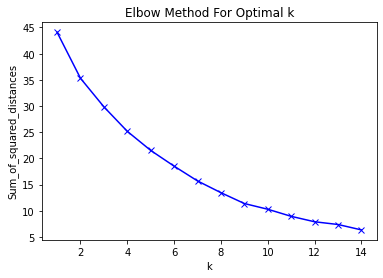

In [332]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [333]:
# add clustering labels to our dataframe
neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adamstuen,2,Bakery,Coffee Shop,Café,Train Station,Theater
1,Aker brygge,0,Café,Coffee Shop,Train Station,Theater,Shopping Mall
2,Alna,4,Furniture / Home Store,Shopping Mall,Electronics Store,Café,Train Station
3,Berg,2,Clothing Store,Bakery,Train Station,Theater,Shopping Mall
4,Bislett,4,Coffee Shop,Pub,Café,Bakery,Train Station


In [334]:
# now the loop for all neighborhoods with lat/lon coordinates in order to vizualise in which cluster belong each neighborhood
list_latitude = []
list_longitude = []
geolocator = Nominatim(user_agent="oslo_agent")

from tqdm.auto import tqdm # useful to vizualise running time, around 45 seconds min

for neigh in tqdm(neighborhoods_venues_sorted['Neighborhood'].values):
    address = '{},Oslo, NO'.format(neigh)
    geolocator = Nominatim(user_agent="oslo_agent")
    location = geolocator.geocode(address)
    list_latitude.append(location.latitude)
    list_longitude.append(location.longitude)

In [335]:
neighborhoods_venues_sorted.insert(1, 'Longitude', list_longitude)
neighborhoods_venues_sorted.insert(1, 'Latitude', list_latitude)

In [336]:
neighborhoods_venues_sorted.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adamstuen,59.932728,10.734403,2,Bakery,Coffee Shop,Café,Train Station,Theater
1,Aker brygge,59.909928,10.725042,0,Café,Coffee Shop,Train Station,Theater,Shopping Mall
2,Alna,59.932417,10.835276,4,Furniture / Home Store,Shopping Mall,Electronics Store,Café,Train Station
3,Berg,59.951247,10.745366,2,Clothing Store,Bakery,Train Station,Theater,Shopping Mall
4,Bislett,59.925553,10.731894,4,Coffee Shop,Pub,Café,Bakery,Train Station


#### Plotting clusters on Oslo map

We will see that there is 
- One big cluster number k = 0 (concentrated mostly on Oslo downtown and dense boroughs)
- Four little clusters (6 to 9 elements) with specific characteristics

In [337]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Latitude'], neighborhoods_venues_sorted['Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

#### Examine each clusters in order to find some useful insights

In [338]:
def numb(cluster):
    a = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == cluster].shape[0]
    return a

In [339]:
for i in range(0,5):
    print("Number of neighborhoods in cluster {} : {} neighborhoods".format(i, numb(i)))

Number of neighborhoods in cluster 0 : 10 neighborhoods
Number of neighborhoods in cluster 1 : 10 neighborhoods
Number of neighborhoods in cluster 2 : 21 neighborhoods
Number of neighborhoods in cluster 3 : 8 neighborhoods
Number of neighborhoods in cluster 4 : 35 neighborhoods


In [340]:
# Cluster 0 : concentrated on dense areas, with already lot of coffee shops 
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 0].head(20)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Aker brygge,59.909928,10.725042,0,Café,Coffee Shop,Train Station,Theater,Shopping Mall
6,Bjølsen,59.940508,10.759192,0,Café,Electronics Store,Dessert Shop,Bar,Bakery
11,Bygdøy,59.906995,10.679746,0,Café,Train Station,Theater,Shopping Mall,Pub
14,Enerhaugen,59.913294,10.769124,0,Café,Coffee Shop,Train Station,Theater,Shopping Mall
18,Frogner,59.922224,10.706649,0,Café,Furniture / Home Store,Train Station,Theater,Shopping Mall
31,Hoff,59.929658,10.675400,0,Café,Art Gallery,Train Station,Theater,Shopping Mall
45,Lilleaker,59.923150,10.639532,0,Café,Train Station,Theater,Shopping Mall,Pub
61,Sagene,59.936887,10.755306,0,Café,Bar,Train Station,Theater,Shopping Mall
65,Skarpsno,59.914348,10.702332,0,Café,Train Station,Theater,Shopping Mall,Pub
83,Åsbråten,59.828008,10.782272,0,Café,Train Station,Theater,Shopping Mall,Pub


In [341]:
# Cluster 1 : look the most interesting 
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 1].head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,Bogerud,59.876219,10.842116,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
39,Kalbakken,59.954778,10.866958,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
43,Lambertseter,59.873364,10.810371,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
52,Mortensrud,59.849287,10.829698,1,Shopping Mall,Bakery,Train Station,Theater,Pub
54,Oppsal,59.892992,10.839837,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
55,Prinsdal,59.833067,10.807914,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
56,Ris,59.946205,10.702969,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
59,Romsås,59.962615,10.892461,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
64,Sjøtomta,59.909619,10.754703,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store
71,Stovner,59.962140,10.922823,1,Shopping Mall,Train Station,Theater,Pub,Furniture / Home Store


In [345]:
# Cluster 2 : look like interesting especially some neighborhoods (Gimle, Holtet, Linderud,...)
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 2].head(21)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adamstuen,59.932728,10.734403,2,Bakery,Coffee Shop,Café,Train Station,Theater
3,Berg,59.951247,10.745366,2,Clothing Store,Bakery,Train Station,Theater,Shopping Mall
12,Carl Berner,59.926126,10.775939,2,Furniture / Home Store,Coffee Shop,Bakery,Train Station,Theater
15,Fagerborg,59.929502,10.726581,2,Café,Bakery,Train Station,Theater,Shopping Mall
16,Filipstad,59.910825,10.716861,2,Cocktail Bar,Bakery,Train Station,Theater,Shopping Mall
20,Gamle Oslo,59.899237,10.734767,2,Coffee Shop,Bakery,Electronics Store,Bar,Train Station
22,Gimle,59.916347,10.706452,2,Bakery,Train Station,Theater,Shopping Mall,Pub
33,Holtet,59.943085,10.636071,2,Bakery,Train Station,Theater,Shopping Mall,Pub
46,Linderud,59.940963,10.838420,2,Bakery,Train Station,Theater,Shopping Mall,Pub
48,Lovisenberg,59.933379,10.747348,2,Bakery,Train Station,Theater,Shopping Mall,Pub


In [343]:
# Cluster 3 : looks like interesting
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 3].head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
23,Grorud,59.961424,10.880549,3,Train Station,Brewery,Theater,Shopping Mall,Pub
27,Haugenstua,59.951474,10.908540,3,Train Station,Theater,Shopping Mall,Pub,Furniture / Home Store
28,Hauketo,59.847015,10.806027,3,Train Station,Theater,Shopping Mall,Pub,Furniture / Home Store
32,Holm,59.830839,10.794767,3,Train Station,Shopping Mall,Theater,Pub,Furniture / Home Store
35,Høybråten,59.947995,10.927620,3,Train Station,Theater,Shopping Mall,Pub,Furniture / Home Store
36,Høyenhall,59.905908,10.819796,3,Train Station,Bar,Theater,Shopping Mall,Pub
41,Kastellet,59.870296,10.790310,3,Train Station,Theater,Shopping Mall,Pub,Furniture / Home Store
47,Ljan,59.852780,10.784992,3,Train Station,Theater,Shopping Mall,Pub,Furniture / Home Store


In [346]:
# Cluster 4 : already crowded by coffee-shops, essentially downtown, except Alna neighborhood
neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 4].head(35)

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Alna,59.932417,10.835276,4,Furniture / Home Store,Shopping Mall,Electronics Store,Café,Train Station
4,Bislett,59.925553,10.731894,4,Coffee Shop,Pub,Café,Bakery,Train Station
5,Bjerke,59.940668,10.808725,4,Train Station,Shopping Mall,Furniture / Home Store,Café,Theater
7,Bjørvika,59.908382,10.754553,4,Coffee Shop,Train Station,Theater,Shopping Mall,Pub
9,Bolteløkka,59.928825,10.734031,4,Pub,Train Station,Theater,Shopping Mall,Furniture / Home Store
10,Briskeby,59.921150,10.716572,4,Coffee Shop,Café,Brewery,Bar,Train Station
13,Dælenenga,59.927642,10.762951,4,Café,Brewery,Coffee Shop,Bar,Pub
17,Fredensborg,59.898758,10.676228,4,Bar,Cocktail Bar,Train Station,Theater,Shopping Mall
19,Galgeberg,59.907229,10.778955,4,Pub,Train Station,Theater,Shopping Mall,Furniture / Home Store
21,Gamlebyen,59.904354,10.769846,4,Coffee Shop,Café,Cocktail Bar,Bakery,Train Station


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of coffee shops in Oslo, there are still areas with relative few of them and high number of others places of interest (like stores and shops). Highest concentration of coffee shops was detected in downtown, north and Oslo center, so we focused our attention to areas south and east, corresponding to cluster 3 and also somme neighborhoods like Alna and Sondre Nordstrand to name only those (these last ones where better detected in our visualization analysis with Cognos Analytics).

However, stakeholder willing to open a coffee shop in Sentrum (downtown) could also use our analysis to find small pockets with relative few number of coffee shops, as they have a geolocalisation of the coffee shops and relatives on a detailed map of Oslo. They can check street by street their ideal location, knowing exactly where their competitors are, as well as potential customers doing shopping.

See the previous map of coffee shops and shopping stores distribution.



## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Oslo areas with low number of coffee shops in order to help stakeholders in narrowing down the search for optimal location for a new trendy coffee shop. By calculating coffee shop density distribution from Foursquare data we have first identified general boroughs that justify further analysis. Clustering of coffee-shops family (bar, café, coffee-shops) and shopping family (stores, mall,..) then will confirm our intuition and visualization work by revealing major zones of interest (containing greatest number of potential locations).

Final decision on optimal coffee shop location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity historical monuments, parks,...), levels of noise / proximity to major roads or railways, real estate availability, prices, social and economic dynamics of every neighborhood etc.

Thanks for your reading !